<a href="https://colab.research.google.com/github/brunocosouza/NLP/blob/main/The_Dataset_for_Pretraining_Word_Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install -U d2l

In [ ]:
from d2l import torch as d2l
import math
import torch
import os
import random

O dataset ja foi preprocessado. Cada linha atua como uma sentença. Todas as palavras em uma sentença são separadas por espaço. Cada palavra é um token.


In [ ]:
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip',
                       '319d85e578af0cdc590547f26231e4e31cdf1e42')

In [ ]:
d2l.DATA_HUB['ptb']

('http://d2l-data.s3-accelerate.amazonaws.com/ptb.zip',
 '319d85e578af0cdc590547f26231e4e31cdf1e42')

In [ ]:
def read_ptb():
  data_dir = d2l.download_extract('ptb')
  with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
    raw_text = f.read()
  return [line.split() for line in raw_text.split('\n')]

In [ ]:
sentences = read_ptb()

In [ ]:
f'# sentences: {len(sentences)}'

'# sentences: 42069'

In [ ]:
vocab = d2l.Vocab(sentences, min_freq = 10)
f'vocab size: {len(vocab)}'

'vocab size: 6719'

In [ ]:
x = [[tk for tk in line] for line in sentences]

In [ ]:
vocab[x[1]], x[1]

([0, 0, 2, 71, 392, 32, 2115, 1, 145, 18, 5, 0, 274, 406, 2],
 ['pierre',
  '<unk>',
  'N',
  'years',
  'old',
  'will',
  'join',
  'the',
  'board',
  'as',
  'a',
  'nonexecutive',
  'director',
  'nov.',
  'N'])

# Subamostragem

Em texto, normalmente, tem-se palavras que aparecem com maior frequência. Usualmente, é melhor treinar um modelo de word embedding quando a palavra e um palavra de frequência menor aparecem ao mesmo tempo, por exemplo "chip" e "microprocessador", ao inves de quando a palavra aparece em alta frequência, por exemplo o artigo "a". Portanto, quando treinamos um modelo de word embedding, performamos a subamostragem nas palavras (Milolov, T. Distributed representations of words and phrases and their compositionality).

In [ ]:
#@save
def subsampling(sentences, vocab):
    # Map low frequency words into <unk>
    sentences = [[vocab.idx_to_token[vocab[tk]] for tk in line]
                 for line in sentences]
    # Count the frequency for each word
    counter = d2l.count_corpus(sentences)
    num_tokens = sum(counter.values())

    def keep(token):
      return(random.uniform(0,1) < 
             math.sqrt(1e-4/counter[token] * num_tokens))
      
    return [[tk for tk in line if keep(tk)] for line in sentences]

In [ ]:
subsampled = subsampling(sentences, vocab)

In [ ]:
subsampled[1],sentences[1]

(['join', 'board'],
 ['pierre',
  '<unk>',
  'N',
  'years',
  'old',
  'will',
  'join',
  'the',
  'board',
  'as',
  'a',
  'nonexecutive',
  'director',
  'nov.',
  'N'])

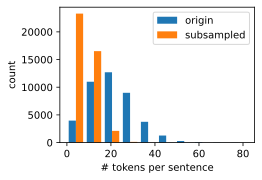

In [ ]:
d2l.set_figsize()
d2l.plt.hist([[len(line) for line in sentences],
              [len(line) for line in subsampled]])
d2l.plt.xlabel('# tokens per sentence')
d2l.plt.ylabel('count')
d2l.plt.legend(['origin', 'subsampled']);

In [ ]:
def compare_count(token):
  return(f'Information of "{token}": ' 
         f'before = {sum([line.count(token) for line in sentences])}, '
         f'after = {sum([line.count(token) for line in subsampled])}')

In [ ]:
compare_count('the'), compare_count('join')

('Information of "the": before = 50770, after = 2058',
 'Information of "join": before = 45, after = 45')

In [ ]:
#Map each token into an index to construct the corpus
corpus = [vocab[line] for line in subsampled]

subsampled[1:3], corpus[1:3]

([['join', 'board'], ['n.v.', 'dutch', 'publishing', 'group']],
 [[2115, 145], [5277, 3054, 1580, 95]])

## Extraindo Central Target e Context Words

In [ ]:
def get_negatives(all_contexts, corpus, K):
    counter = d2l.count_corpus(corpus)
    sampling_weights = [counter[i]**0.75 for i in range(len(counter))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # Noise words cannot be context words
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

In [ ]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('dataset', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('center', center, 'has contexts', context)

dataset [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
center 0 has contexts [1]
center 1 has contexts [0, 2]
center 2 has contexts [0, 1, 3, 4]
center 3 has contexts [2, 4]
center 4 has contexts [2, 3, 5, 6]
center 5 has contexts [4, 6]
center 6 has contexts [4, 5]
center 7 has contexts [8, 9]
center 8 has contexts [7, 9]
center 9 has contexts [8]


In [ ]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# center-context pairs: {len(all_centers)}'

'# center-context pairs: 352659'

In [ ]:
all_centers[5], all_contexts[5], vocab[subsampled[2]]

(95, [5277, 3054, 1580], [5277, 3054, 1580, 95])

## Negative Sampling

In [ ]:
class RandomGenerator:
  def __init__(self, sampling_weights):
    self.population = list(range(len(sampling_weights)))
    self.sampling_weights = sampling_weights
    self.candidates = []
    self.i = 0

  def draw(self):
    if self.i == len(self.candidates):
      self.candidates = random.choices(
          self.population, self.sampling_weights, k=10000)
      self.i = 0
    self.i += 1
    return self.candidates[self.i-1]

generator = RandomGenerator([4,5,6,7])
[generator.draw() for _ in range(10)]

[1, 0, 1, 3, 3, 2, 1, 3, 3, 1]

In [ ]:
def get_negatives(all_contexts, corpus, K):
  counter = d2l.count_corpus(corpus)
  sampling_weights = [counter[i]**0.75 for i in range(len(counter))]
  all_negatives, generator = [], RandomGenerator(sampling_weights)
  for contexts in all_contexts:
    negatives = []
    while len(negatives) < len(contexts) * K:
      neg = generator.draw()
      if neg not in contexts:
        negatives.append(neg)
    all_negatives.append(negatives)
  return all_negatives

all_negatives = get_negatives(all_contexts, corpus, 5)

In [ ]:
#All_negatives are the noise words of each central target word
len(all_negatives), len(all_centers)

(352659, 352659)

## Lendo em batches

O minibatch de dados deve conter a central word e seus correspondentes context words e noise words (negative sampling). Como os tamanhos dos dados pode ser diferentes, completamos os minibatchs menores com padding (adicionando 0s). Para identificação de valores e padding criaremos uma variavel mask que vai identificar como 1 valores reais ou 0 caso contrario. Além disso, uma variavel labels vai identificar os elementos correspondentes ao contexto (1) ou ao negative_sampling (0).

In [ ]:
def batchify(data):
  max_len = max(len(c) + len(n) for _, c, n in data)
  centers, contexts_negatives, masks, labels = [], [], [], []
  for center, context, negative in data:
    cur_len = len(context) + len(negative)
    centers += [center]
    contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
    masks += [[1] * cur_len + [0] * (max_len - cur_len)]
    labels += [[1] * len(context) + [0] * (max_len - len(context))]
  return (d2l.reshape(torch.tensor(centers), (-1, 1)), torch.tensor(contexts_negatives),
          torch.tensor(masks), torch.tensor(labels))

In [ ]:
x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


## Definindo o Dataload

In [ ]:
def load_data_ptb(batch_size, max_window_size, num_noise_words):
  num_workers = d2l.get_dataloader_workers()
  sentences = read_ptb()
  vocab = d2l.Vocab(sentences, min_freq = 10)
  subsampled = subsampling(sentences, vocab)
  corpus = [vocab[line] for line in subsampled]
  all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
  all_negatives = get_negatives(all_contexts, corpus, num_noise_words)

  class PTBDataset(torch.utils.data.Dataset):
    def __init__(self, centers, contexts, negatives):
      assert len(centers) == len(contexts) == len(negatives)
      self.centers = centers
      self.contexts = contexts
      self.negatives = negatives

    def __getitem__(self, index):
      return (self.centers[index], self.contexts[index], self.negatives[index])

    def __len__(self):
      return len(self.centers)

  dataset = PTBDataset(
      all_centers, all_contexts, all_negatives)
  
  data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle = True,
                                          collate_fn = batchify,
                                          num_workers = num_workers)
  
  return data_iter, vocab

In [ ]:
data_iter, vocab = load_data_ptb(512, 5, 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


# Pretraining word2vec

Agora estamos pronto para treinar a skip-gram model.

In [ ]:
from torch import nn
batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = d2l.load_data_ptb(batch_size, max_window_size,
                                     num_noise_words)

## Camada de Embedding

A camada do modelo que "embed" a palavra (vetorização da palavra) é denomidada embedding layer. Para a tarefa, utilizaremos nn.Embedding instancia do Pytorch. Os pesos da camada de embedding é uma matriz no qual as linhas se referem ao tamanho do dicionario (vocabulario) e as colunas representam a dimensão que cada palavra for vetorizada.

In [ ]:
embed = nn.Embedding(num_embeddings = 20, embedding_dim = 4)
print(f'Parameter embedding_weight: ({embed.weight.shape},' 
        f' dtype = {embed.weight.dtype})')

Parameter embedding_weight: (torch.Size([20, 4]), dtype = torch.float32)


In [ ]:
x = torch.tensor([[0, 2, 3], [3, 4, 19]])
embed(x)

tensor([[[-0.5085,  0.8045,  0.9752, -0.1291],
         [-0.2517,  0.2282,  0.5423,  0.2249],
         [ 0.3163,  1.9566, -0.4500, -0.1873]],

        [[ 0.3163,  1.9566, -0.4500, -0.1873],
         [-0.3806,  0.8487, -1.1120,  0.3080],
         [ 0.9016, -0.7213, -2.8529,  0.1596]]], grad_fn=<EmbeddingBackward>)

## Skip-gram Model Forward Calculation

No calculo da passada para frente, a entrada do modelo skip-gram contém a palavra central (alvo) e a concatenação do context e da noise word (indexados como contexts_and_negatives). Para relembrar o shape de cada variavel:

*   center_work = (batch_size, 1)
*   contexts_and_negatives = (batch_size, max_len)

As variaveis em questão serão transformadas de word indexes para word vetor (vetorizadas) pela camada de embedding do modelo. A saida tera o shape de (batch_size, 1, max_len). Cada elemento no output é o produto interno da center word vector (target) e do context word vector or noise word vector.





In [ ]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
  v = embed_v(center)
  u = embed_u(contexts_and_negatives)
  pred = torch.bmm(v, u.permute(0, 2, 1))
  return pred

In [ ]:
skip_gram(torch.ones((2, 1), dtype=torch.long), 
          torch.ones((2, 4), dtype=torch.long), embed, embed).shape

torch.Size([2, 1, 4])

In [ ]:
skip_gram(torch.ones((2, 1), dtype=torch.long), 
          torch.ones((2, 4), dtype=torch.long), embed, embed)

tensor([[[6.9319, 6.9319, 6.9319, 6.9319]],

        [[6.9319, 6.9319, 6.9319, 6.9319]]], grad_fn=<BmmBackward0>)

# Treinamento do modelo

Para treinar o modelo, primeiramente devemos definir a função de perda do modelo (loss function).

Segundo à definição da função de perda da negative sampling usaremos a binary cross-entropy loss function.

In [ ]:
class SigmoidBCELoss(nn.Module):
  def __init__(self):
    super().__init__

  def forward(self, inputs, target, mask = None):
    out = nn.functional.binary_cross_entropy_with_logits(
        inputs, target, weight = mask, reduction = 'none')
    return out.mea(dim = 1)

In [ ]:
loss = SigmoidBCELoss()

In [ ]:
pred = torch.tensor([[.5]*4]*2)
label = torch.tensor([[1., 0., 1., 0.]]*2)
mask = torch.tensor([[1, 0, 1, 1], [1, 1, 0, 1]])

pred, label, mask

(tensor([[0.5000, 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000, 0.5000]]), tensor([[1., 0., 1., 0.],
         [1., 0., 1., 0.]]), tensor([[1, 0, 1, 1],
         [1, 1, 0, 1]]))

In [ ]:
loss(pred, label, mask)

tensor([0.4806, 0.6056])

In [ ]:
loss(pred, label, mask) / mask.sum(axis = 1) * mask.shape[1]

tensor([0.6407, 0.8074])

### Inicializando os parametros do Modelo

In [ ]:
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim = embed_size),
                    nn.Embedding(num_embeddings = len(vocab),
                                 embedding_dim = embed_size))

### Treinando o modelo

In [ ]:
def train(net, data_iter, lr, num_epochs, device = d2l.try_gpu()):
  def init_weights(m):
    if type(m) == nn.Embedding:
      nn.init.xavier_uniform(m.weight)
  net.apply(init_weights)
  net = net.to(device)
  optimizer = torch.optim.Adam(net.parameters(), lr = lr)
  animator = d2l.Animator(xlabel = 'epoch', ylabel='loss', xlim = [1, num_epochs])
  metric = d2l.Accumulator(2)
  for epoch in range(num_epochs):
    timer, num_batches = d2l.Timer(), len(data_iter)
    for i, batch in enumerate(data_iter):
      optimizer.zero_grad()
      center, context_negative, mask, label = [data.to(device) for data in batch]
      
      pred = skip_gram(center, context_negative, net[0], net[1])
      l = (loss(pred.reshape(label.shape).float(), label.float(), mask) / mask.sum(axis = 1) * mask.shape[1])
      l.sum().backward()
      optimizer.step()
      metric.add(l.sum(), l.numel())
      if (i + 1) % (num_batches // 5) == 0 or i == num_batches -1:
        animator.add(epoch + (i+1) / num_batches,
                     (metric[0] / metric[1],))
  print(f'loss {metric[0] / metric[1]:.3f}, ' 
        f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')


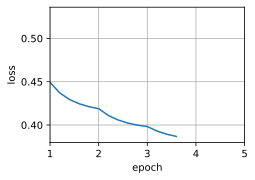

In [ ]:
lr, num_epochs = 0.01, 5
train(net, data_iter, lr, num_epochs)